<a href="https://colab.research.google.com/github/ShreyanshJoshi/Facial-Demographics-using-CNN/blob/master/BEST_More_data_Augmented_Age_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Estimation using Deep CNNs

**Dataset: WIKI Face**

Along with IMDB dataset, it's the largest public dataset of face images with age and gender labels.<font color='green'> WIKI Dataset consists of 62308 images crawled from all profile images from pages of people from Wikipedia with the same meta information.</font>

Consequently, don't expect the model to perform well on people below 25 or above 75-80 per se. That's because,  90 % of the images lie between 20-75 years of age. The model, despite all our efforts, would overfit to such images. In other words, there the distribution on which model has been trained is altogether different than what it could be tested on.

This notebook has a model that's created using with the `Image Data Generator` of Keras. Hence, there was no limitation of RAM in Google Colab, and the image size i chose was 180 x 180 x 3. Here, the path of images was fed to the IDG, which the extracted batches of 64 from there, augmented and then trained the network on those augmented images.

#### **NOTE: More Images !**

 In this notebook, I relaxed the constraints for input images to the model. Minimum requirement of face_Score now is 1.75 as compared to 3 before. Hence, I got more images to train (34,200 as compared to 22,578 before).

More images reduce overfitting and improve performance in real life, especially when in real life you don't expect ppl to upload crystal clear images. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Let's unzip the data that we have presently in zipped format, in the below location

!unzip "/content/drive/My Drive/wiki_crop.zip"              


Streaming output truncated to the last 5000 lines.
  inflating: wiki_crop/93/1020893_1945-04-29_1968.jpg  
  inflating: wiki_crop/93/1021093_1973-01-17_2008.jpg  
  inflating: wiki_crop/93/10281093_1939-12-30_2010.jpg  
  inflating: wiki_crop/93/3023093_1951-12-03_2006.jpg  
  inflating: wiki_crop/93/4024793_1944-09-19_1977.jpg  
  inflating: wiki_crop/93/11219693_1983-04-19_2005.jpg  
  inflating: wiki_crop/93/11225193_1982-07-05_2009.jpg  
  inflating: wiki_crop/93/11282893_1969-03-20_2015.jpg  
  inflating: wiki_crop/93/11294993_1983-09-27_2012.jpg  
  inflating: wiki_crop/93/2122293_1957-04-24_2014.jpg  
  inflating: wiki_crop/93/2126093_1985-06-19_2010.jpg  
  inflating: wiki_crop/93/31225793_1960-02-02_2009.jpg  
  inflating: wiki_crop/93/31254793_1953-09-28_2011.jpg  
  inflating: wiki_crop/93/412193_1895-08-13_1940.jpg  
  inflating: wiki_crop/93/412993_1930-12-17_1993.jpg  
  inflating: wiki_crop/93/7126493_1968-12-30_2006.jpg  
  inflating: wiki_crop/93/12272693_1929-08-27_20

In [ ]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D
from keras.layers import Convolution2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
mat = scipy.io.loadmat('wiki_crop/wiki.mat')

# Reading Matlab files with SciPy

In [ ]:
mat         # Matlab file

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016',
 '__version__': '1.0',
 'wiki': array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
         array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
         array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
         array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
         array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
         array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
       dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
         array(['Dettmar Cramer'], dtype='<U14'),
         array(['Marc Okrand'], dtype='<U11'), ...,
         array(['Michael Wiesinger'], dtype='<U17'),
         array(['Johann Grugger

In [ ]:
# Converting into pandas dataframe. Always easier and better to deal with :)

instances = mat['wiki'][0][0][0].shape[1]
 
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
 
df = pd.DataFrame(index = range(0,instances), columns = columns)
 
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        
for j in range(len(current_array)):
    df[columns[j]] = pd.DataFrame(current_array[j][0])

In [ ]:
df.head()               # Lets see how exactly our dataset looks

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


Data set contains date of birth (DOB) in `Matlab datenum` format.
Converting DOB to Python format. We just need the birth year.

PS: I copy-pasted this code :P

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62328 entries, 0 to 62327
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dob                62328 non-null  int32  
 1   photo_taken        62328 non-null  uint16 
 2   full_path          62328 non-null  object 
 3   gender             59685 non-null  float64
 4   name               62328 non-null  object 
 5   face_location      62328 non-null  object 
 6   face_score         62328 non-null  float64
 7   second_face_score  4096 non-null   float64
dtypes: float64(3), int32(1), object(3), uint16(1)
memory usage: 3.2+ MB


In [ ]:
from datetime import datetime, timedelta
def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) - timedelta(days=366)

    return exact_date.year
 
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [ ]:
df['age'] = df['photo_taken'] - df['date_of_birth']          # Getting present age

In [ ]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981,28
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248,1925,39
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948,60
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,1930,31
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971,41


Lots of unwanted stuff seems to be there.

In [ ]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]
 
#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]

#some guys seem to be greater than 100. Let's remove them and first make a model that classifies from
# 1 to 100
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set i.e age < 0
df = df[df['age'] > 0]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40157 entries, 0 to 62327
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dob                40157 non-null  int32  
 1   photo_taken        40157 non-null  uint16 
 2   full_path          40157 non-null  object 
 3   gender             39397 non-null  float64
 4   name               40157 non-null  object 
 5   face_location      40157 non-null  object 
 6   face_score         40157 non-null  float64
 7   second_face_score  0 non-null      float64
 8   date_of_birth      40157 non-null  int64  
 9   age                40157 non-null  int64  
dtypes: float64(3), int32(1), int64(2), object(3), uint16(1)
memory usage: 3.0+ MB


In [ ]:
#lower threshold for face_score - allows more images of poor quality (making the model more robust)

df = df[df['face_score'] >= 1.75]
 
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])

In [ ]:
df.info()     # Only gender has null values. Since, this project deals with age estimation
              # only, we needn't worry about those. We would anyways be dropping gender
              # column after EDA

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34200 entries, 0 to 62327
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dob          34200 non-null  int32  
 1   photo_taken  34200 non-null  uint16 
 2   full_path    34200 non-null  object 
 3   gender       33550 non-null  float64
 4   age          34200 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(1), uint16(1)
memory usage: 1.2+ MB


In [ ]:
df.head()

# GENDER: 0 - female , 1-male , NaN - unknown

,dob,photo_taken,full_path,gender,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34


In [ ]:
df.describe()

,dob,photo_taken,gender,age
count,34200.000000,34200.000000,33550.000000,34200.000000
mean,717156.505731,2001.503012,0.740447,38.492661
std,9180.800332,19.586437,0.438396,16.469871
min,677987.000000,1940.000000,0.000000,1.000000
25%,711082.000000,2006.000000,0.000000,26.000000
50%,719659.500000,2010.000000,1.000000,33.000000
75%,724768.250000,2013.000000,1.000000,49.000000
max,734922.000000,2015.000000,1.000000,100.000000


In [ ]:
df['path'] = [str(np.squeeze(i)) for i in df['full_path']]
df

,dob,photo_taken,full_path,gender,age,path
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28,17/10000217_1981-05-05_2009.jpg
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60,12/100012_1948-07-03_2008.jpg
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41,16/10002116_1971-05-31_2012.jpg
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52,02/10002702_1960-11-09_2012.jpg
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34,41/10003541_1937-09-27_1971.jpg
...,...,...,...,...,...,...
62321,707521,1968,[38/9996938_1937-02-15_1968.jpg],1.0,31,38/9996938_1937-02-15_1968.jpg
62322,709971,1968,[46/9996946_1943-11-01_1968.jpg],1.0,25,46/9996946_1943-11-01_1968.jpg
62323,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,26,49/9996949_1937-04-17_1963.jpg
62325,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,41,09/9998109_1972-12-27_2013.jpg


After looking at all data and their datatypes and cleaning the data, to get relevant columns,  lets analyze the data and its distribution, for better understanding of dataset.

## EDA (Exploratory Data Analysis)

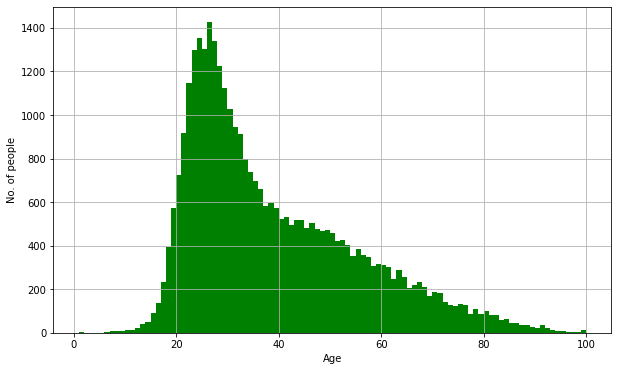

In [ ]:
 df['age'].hist(bins=df['age'].nunique(),color='g',figsize=(10,6))  

# Pretty obvious that a large chunk of population in training data is from 20 to 60
# Sort of bell-shaped curve (Gaussian Distribution)  -very non uniform
# Mean age is 38.2

plt.xlabel('Age')
plt.ylabel('No. of people')
plt.show()

Pretty obvious that a large chunk of population in training data is from 20 to 60. Sort of bell-shaped curve (Gaussian Distribution) -very non uniform.

This should not come as a surprise, as WIKI dataset contains profile pictures of ppl from Wikipedia. Of course, you cannot expect babies or lot of children below 20 to have their own Wikipedia page. Similarly, not much older people also have Wikipedia pages.

Mean age is 38.492

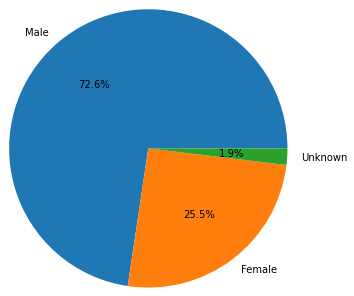

In [ ]:
x1 = df[df['gender']==1]['gender'].count()
x2 = df[df['gender']==0]['gender'].count()
inp = [x1,x2,650]
lab = ['Male', 'Female', 'Unknown']

plt.pie(inp, labels=lab,radius=1.6,autopct='%.1f%%')
plt.show()

# Clearly, the dataset is heavily imbalanced in favour of males

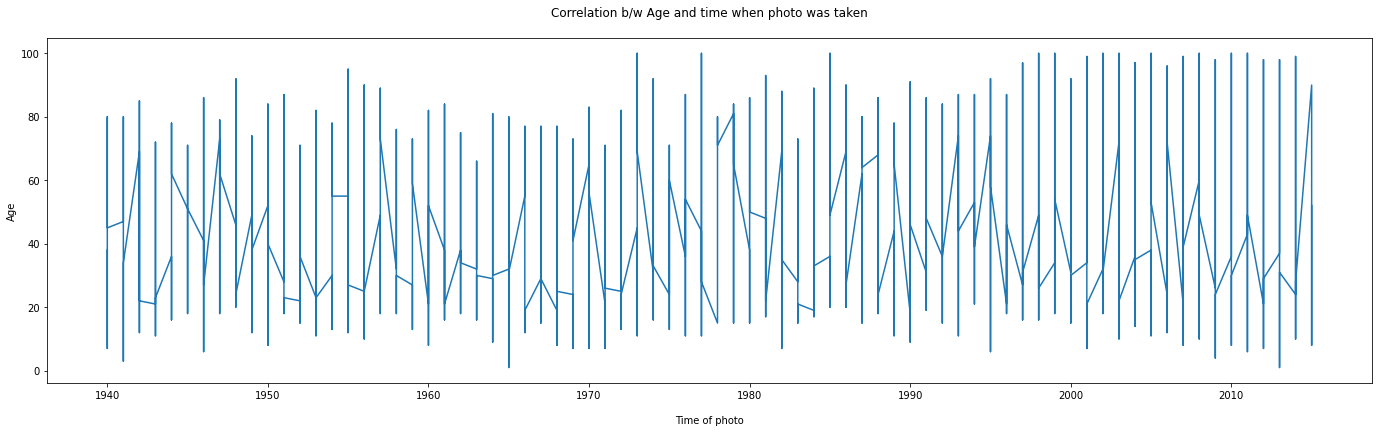

In [ ]:
x = df.sort_values(by='photo_taken')

fig= plt.figure(figsize=(23,6))                        # width and height of plot in unit inches
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(x['photo_taken'],x['age'])
plt.title('Correlation b/w Age and time when photo was taken\n')
plt.xlabel('\nTime of photo')
plt.ylabel('Age')
plt.show()

# Shows that irrespective of when photo was taken, almost always ppl between 20-70
# have been covered.


The above graph, just tells us that people of different age groups were there irrespective of when the photo was taken. It does NOT tell us about the number of photos taken for each group. For that, let's plot the mean age for each year in which photo was taken

In [ ]:
df_copy = df.groupby(['photo_taken'], as_index=False).mean()
df_copy.head()

# Only interested in mean age

,photo_taken,dob,gender,age
0,1940,695432.028571,0.751196,36.480952
1,1941,695502.101852,0.750000,37.287037
2,1942,695626.866667,0.848739,37.933333
3,1943,696896.269565,0.745614,35.434783
4,1944,696866.064815,0.859813,36.583333


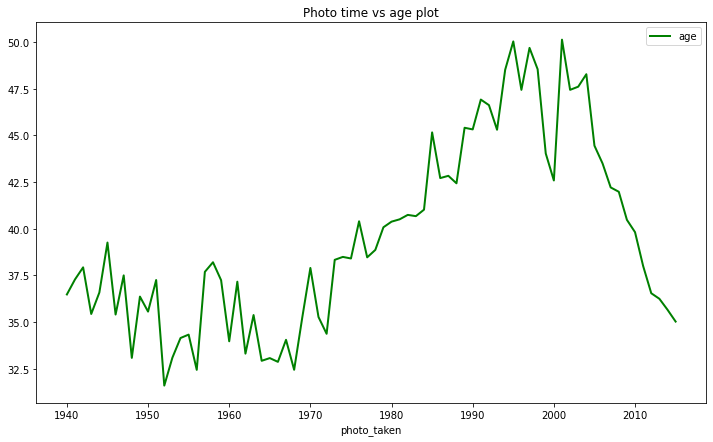

In [ ]:
df_copy.plot(x = 'photo_taken', y = 'age', figsize = (12,7), color = 'green', linewidth =2)
plt.title("Photo time vs age plot")
plt.xticks(rotation=0)
plt.show()

# Clearly, more aged people  were photographed during 1980-2005. There seems to be some
# correlation !

### Pixel based EDA on images

Let's study these pixels a bit.

### What are pixels ?
Pixel is the smallest element of an image. Each pixel correspond to any one value. In an 8-bit gray scale image, the value of the pixel between 0 and 255. The value of a pixel at any point correspond to the intensity of the light photons striking at that point.

	
**The range of intensity varies from 0 (black) to 255 (white).**

### Color Images

Color images require more storage space than grayscale images. Pixels in grayscale images need just one byte to indicate the intensity of gray needed to render the pixel on screen. It turns out that any color can be built using the correct combination of red, green, and blue. 
* Thus, pixels in color images are represented by three values (r,g,b). The values indicate the intensity of red, green, and blue, respectively, needed to render the pixel on screen.

*  The range of intensities is exactly the same as grayscale images - 0 means none of the color appears in the pixel and 255 indicates the highest level of the color is evident in the pixel. For example, the triple (128, 0, 128) would represent a medium purple while (255, 215, 0) represents gold.

In [ ]:
# For further EDA on images itself, we need to extract their pixel values

target_size = (180, 180)
 
def get_image_pixel(image_path):
    pic = load_img("wiki_crop/%s" % image_path[0], color_mode='grayscale', target_size=target_size)
    x = img_to_array(pic).reshape(1, -1)[0]
    return x
 
df['pixels'] = df['full_path'].apply(get_image_pixel)

* Keras provides the `load_img()` function for loading an image from file as a 
PIL image object. 

The `load_img()` function provides additional arguments that may be useful when loading the image, such as **grayscale** that allows the image to be loaded in grayscale (defaults to False), **color_mode** that allows the image mode or channel format to be specified (defaults to rgb), and **target_size** that allows a tuple of (height, width) to be specified, resizing the image automatically after being loaded.


* Keras provides the `img_to_array()` function for converting a loaded image in PIL format into a NumPy array for use with deep learning models.

The numpy array essentially is the  pixel data.

In [ ]:
df.head()

,dob,photo_taken,full_path,gender,age,path,pixels
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28,17/10000217_1981-05-05_2009.jpg,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60,12/100012_1948-07-03_2008.jpg,"[95.0, 92.0, 96.0, 96.0, 99.0, 98.0, 93.0, 93...."
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41,16/10002116_1971-05-31_2012.jpg,"[37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37...."
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52,02/10002702_1960-11-09_2012.jpg,"[121.0, 121.0, 121.0, 122.0, 122.0, 123.0, 123..."
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34,41/10003541_1937-09-27_1971.jpg,"[190.0, 204.0, 203.0, 201.0, 204.0, 200.0, 201..."


In [ ]:
x = df['age']           # We have 97 unique age values with us. Only 2,3,4 missing
x = x.sort_values()
x.unique()

array([  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100])

In [ ]:
df['pixels'][0].size

# Each image now is 180 x 180 x 1. Hence has 32,400 pixels (NumPy array)

32400

In [ ]:
# Here, we get the average pixel value for every image

x = df.sort_values(by='age')
x.reset_index(inplace=True)

x['pixel_per_image'] = x['pixels']
x['pixel_deviation_per_image'] = x['pixels']

for i in range(34200):
  x['pixel_per_image'][i] = x['pixels'][i].mean()
  x['pixel_deviation_per_image'][i] = x['pixels'][i].max()-x['pixels'][i].min()

x.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,index,dob,photo_taken,full_path,gender,age,path,pixels,pixel_per_image,pixel_deviation_per_image
0,53357,734922,2013,[27/34853027_2012-02-23_2013.jpg],0.0,1,27/34853027_2012-02-23_2013.jpg,"[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200...",175.384,250
1,5669,717349,1965,[33/6802033_1964-01-13_1965.jpg],1.0,1,33/6802033_1964-01-13_1965.jpg,"[196.0, 196.0, 196.0, 196.0, 196.0, 196.0, 196...",133.574,224
2,41240,707981,1941,[57/35652957_1938-05-21_1941.jpg],1.0,3,57/35652957_1938-05-21_1941.jpg,"[219.0, 181.0, 195.0, 212.0, 180.0, 168.0, 182...",151.887,250
3,42685,732518,2009,[81/37696581_2005-07-25_2009.jpg],1.0,4,81/37696581_2005-07-25_2009.jpg,"[201.0, 201.0, 201.0, 201.0, 201.0, 201.0, 201...",127.414,253
4,53303,731956,2009,[76/24896876_2004-01-10_2009.jpg],0.0,5,76/24896876_2004-01-10_2009.jpg,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....",97.5529,249


First, let's analyse average pixel values per image. We wanna find out whether it has any correlation to gender of the person in the image.

In [ ]:
print(x['pixel_per_image'].min())          

print(x['pixel_per_image'].max())

print(x['pixel_per_image'].mean())     # Average pixel value across all images

11.686481
254.98425
110.10616959064328


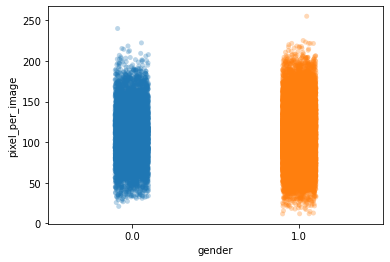

In [ ]:
sns.stripplot(x='gender', y='pixel_per_image', data=x, alpha=0.3, jitter=True);

# There seems no correlation b/w gender and mean_pixel value as such.
# To confirm, let's just check the mean pixel value for male and female
# and try to plot their distribution to see amt of overlap 

In [ ]:
print(x[x['gender']==1]['index'].count())      # male count
print(x[x['gender']==0]['index'].count())      # female count

24842
8708


In [ ]:
sum1=0
sum2=0
for i in range(34200):
    if x['gender'][i]==1:
        sum1+=x['pixel_per_image'][i]
    
    elif x['gender'][i]==0:
        sum2+=x['pixel_per_image'][i]

val1 = sum1/24842                 # Avg pixel value for male
val2 = sum2/8708                  # Avg pixel value for female

print(val1,' ',val2)              # Mean pixel val for male and female

110.37515136107434   109.28285277059553


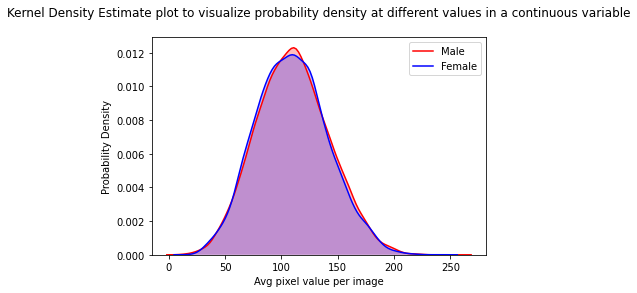

In [ ]:
# Plotting the KDE Plot 
sns.kdeplot(x.loc[(x['gender']==1),'pixel_per_image'], color='r', shade=True, Label='Male') 
  
sns.kdeplot(x.loc[(x['gender']==0),'pixel_per_image'], color='b', shade=True, Label='Female') 
  
plt.xlabel('Avg pixel value per image') 
plt.ylabel('Probability Density') 
plt.title('Kernel Density Estimate plot to visualize probability density at different values in a continuous variable\n')
plt.show()

The extent of overlap, confirms in our mind that there is no correlation between pixel values and gender ! Lets, now combine age, gender and average pixel value in a image.

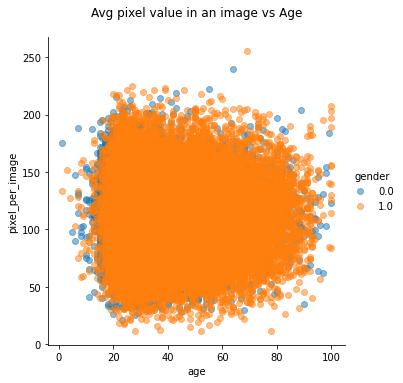

In [ ]:
sns.lmplot(x='age', y='pixel_per_image', hue='gender', data=x, fit_reg=False, scatter_kws={'alpha':0.5})
plt.title('Avg pixel value in an image vs Age\n')
plt.show()

Let's explore  deviation in pixel values (max-min) in an image

In [ ]:
print(x['pixel_deviation_per_image'].min())          

print(x['pixel_deviation_per_image'].max())

print(x['pixel_deviation_per_image'].mean())             # Average pixel deviation across all images

11.0
255.0
245.0925730994152


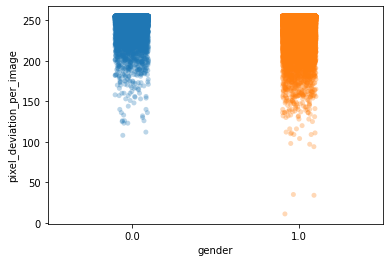

In [ ]:
sns.stripplot(x='gender', y='pixel_deviation_per_image', data=x, alpha=0.3, jitter=True);

# Majority of images have deviation about 230-250. We see a bit more deviation 
# in males, but that could be attributed to the fact that we have 70 % males in 
# the data

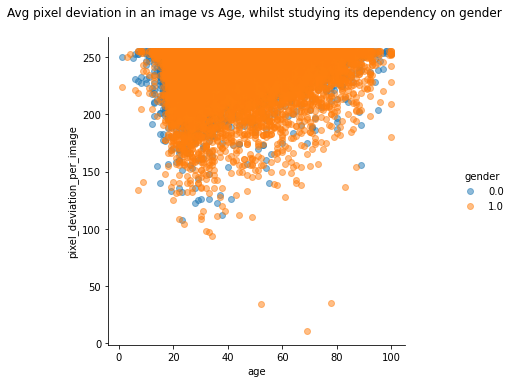

In [ ]:
sns.lmplot(x='age', y='pixel_deviation_per_image', hue='gender', data=x, fit_reg=False, scatter_kws={'alpha':0.5})
plt.title('Avg pixel deviation in an image vs Age, whilst studying its dependency on gender \n')
plt.show()

In [ ]:
# I wanted to find average pixel value for a given age. So some computation is 
# required.

y = pd.DataFrame();
y['age'] = x['age'].unique()
y['mean_pixel'] = 1.1
y['mean_pixel'][0] = (x['pixel_per_image'][0] + x['pixel_per_image'][1])/2
y['mean_pixel'][1] = x['pixel_per_image'][2]
sum=0
count=1
j = 2
for i in range(3,34199):
    if x['age'][i]==x['age'][i+1]:
        sum+=x['pixel_per_image'][i]
        count+=1
    
    else:
        sum+=x['pixel_per_image'][i]
        ans = sum/count
        y['mean_pixel'][j] = ans
        count=1
        sum=0
        j+=1
        
sum+=x['pixel_per_image'][34199]
ans = sum/count
y['mean_pixel'][j] = ans
y.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value 

,age,mean_pixel
0,1,154.478577
1,3,151.886765
2,4,127.414413
3,5,97.552902
4,6,113.383489


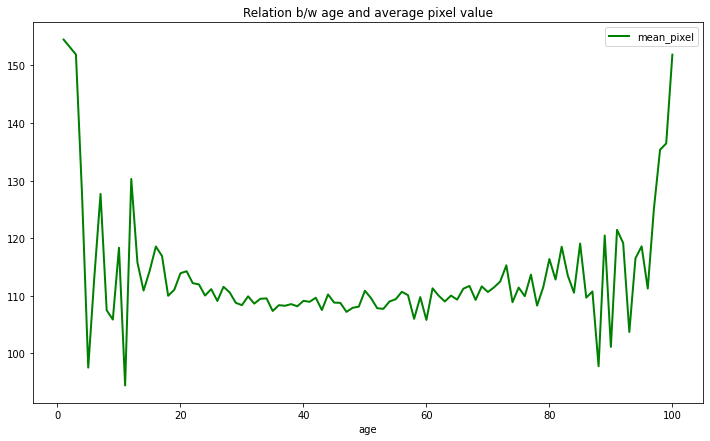

In [ ]:
y.plot(x = 'age' ,y = 'mean_pixel', figsize = (12,7), color = 'green', linewidth =2)
plt.title('Relation b/w age and average pixel value')
plt.xticks(rotation=0)
plt.show()

It seems that on the 2 ends of the spectrum, images have larger pixel values, while in the middle age ranges (20-80), the values plateau out to a roughly constant value.

In [ ]:
pip uninstall keras-preprocessing

Uninstalling Keras-Preprocessing-1.1.2:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras_Preprocessing-1.1.2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/keras_preprocessing/*
Proceed (y/n)? y
  Successfully uninstalled Keras-Preprocessing-1.1.2


In [ ]:
pip install git+https://github.com/keras-team/keras-preprocessing.git -q

## Image Data Generator

Let's create the Image Data Generator, for data augmentation and so that our colab RAM doesn't get exhausted :)

**Note: Only augment images in train set. Validation/test set images must not be augmented.**

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
train = df[:28500]
val = df[28500:]

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255.,                # IDG instance
                           rotation_range=25,
                           brightness_range=[0.7,1.3],
                           zoom_range=0.5,
                           horizontal_flip=True)    

valid_datagen=ImageDataGenerator(rescale=1./255.)               # IDG instance
                           

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory='/content/wiki_crop',
    x_col="path",
    y_col="age",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(180,180))

valid_generator=valid_datagen.flow_from_dataframe(
    dataframe=val,
    directory="/content/wiki_crop",
    x_col="path",
    y_col="age",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(180,180))

Found 28500 validated image filenames.
Found 5700 validated image filenames.


## Model Architecture
Age estimation is a regression problem. 


In [ ]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import SpatialDropout2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l1_l2

input_shape = (180, 180, 3)
inputs = Input(shape=input_shape)

x = SeparableConv2D(64, (3, 3), padding="same")(inputs)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64)(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64)(x)
x = Activation("relu")(x)
x = Dropout(0.20)(x)
x = BatchNormalization()(x)

x = Dense(1)(x)
x = Activation("relu")(x)           # linear also works

age_model = Model(inputs=inputs, outputs=x)

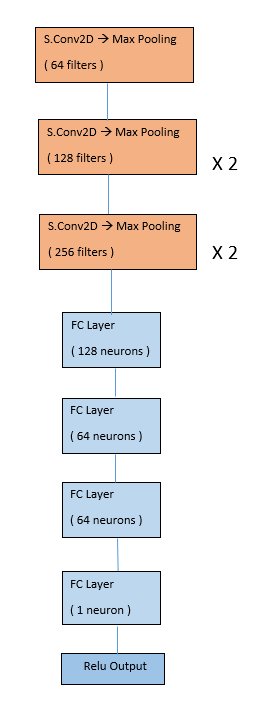

In [ ]:
picture = "/content/drive/My Drive/regress.PNG"                                  
from IPython.display import Image
Image(picture, width=220)

# Model design flowchart

In [ ]:
age_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 180, 180, 64)      283       
_________________________________________________________________
activation_1 (Activation)    (None, 180, 180, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 64)        256       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 90, 90, 128)       8896      
_________________________________________________________________
activation_2 (Activation)    (None, 90, 90, 128)       0   

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.008
	drop = 0.7
	epochs_drop = 12.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='mse', optimizer=opt, metrics=['mae','mse'])

STEP_SIZE_TRAIN=460
STEP_SIZE_VALID=460

history = age_model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,
                     validation_steps=STEP_SIZE_VALID, callbacks=callbacks_list, epochs=45)
  

Epoch 1/45
460/460 [==============================] - 491s 1s/step - loss: 407.4336 - mae: 15.5965 - mse: 407.6204 - val_loss: 319.6818 - val_mae: 12.9888 - val_mse: 249.3381
Epoch 2/45
460/460 [==============================] - 480s 1s/step - loss: 249.0830 - mae: 12.7004 - mse: 248.9811 - val_loss: 177.0636 - val_mae: 11.6202 - val_mse: 217.6165
Epoch 3/45
460/460 [==============================] - 479s 1s/step - loss: 234.3442 - mae: 12.2311 - mse: 234.5299 - val_loss: 275.7580 - val_mae: 10.5532 - val_mse: 193.2431
Epoch 4/45
460/460 [==============================] - 480s 1s/step - loss: 226.6528 - mae: 11.9434 - mse: 226.7023 - val_loss: 204.1180 - val_mae: 12.6257 - val_mse: 246.7557
Epoch 5/45
460/460 [==============================] - 476s 1s/step - loss: 207.7128 - mae: 11.3241 - mse: 207.6200 - val_loss: 324.6176 - val_mae: 14.2057 - val_mse: 286.7829
Epoch 6/45
460/460 [==============================] - 479s 1s/step - loss: 194.1677 - mae: 10.8413 - mse: 194.0430 - val_loss

In [ ]:
age_model.save('/content/drive/My Drive/Colab Notebooks/more_data')
age_model.save('/content/drive/My Drive/Colab Notebooks/more_data.h5')

Let's analyse our performance using some graphs.


In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Total loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mae'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mae'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val mean absolute error',
                  xaxis_title='Epoch',
                  yaxis_title='mae')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mse'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mse'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val mean squared error',
                  xaxis_title='Epoch',
                  yaxis_title='mse')


fig.show()

<Figure size 432x288 with 0 Axes>

Clearly, there is still lot of scope for improvement - no saturation in performance yet. Both val & train performance seems to be improving in *mae*, *mse*.
Let's train some more

In [ ]:
history = age_model.fit_generator(generator=train_generator,steps_per_epoch=460, validation_data=valid_generator,
                     validation_steps=460, callbacks=callbacks_list, epochs=25)
  

Epoch 1/25
460/460 [==============================] - 479s 1s/step - loss: 110.9467 - mae: 7.9449 - mse: 110.9005 - val_loss: 136.0932 - val_mae: 7.2853 - val_mse: 99.1775
Epoch 2/25
460/460 [==============================] - 473s 1s/step - loss: 109.9409 - mae: 7.9122 - mse: 109.9314 - val_loss: 94.8163 - val_mae: 7.0858 - val_mse: 89.8261
Epoch 3/25
460/460 [==============================] - 475s 1s/step - loss: 111.0355 - mae: 7.9504 - mse: 111.1374 - val_loss: 82.5828 - val_mae: 7.0897 - val_mse: 92.3160
Epoch 4/25
460/460 [==============================] - 476s 1s/step - loss: 109.4075 - mae: 7.8909 - mse: 109.4075 - val_loss: 65.5491 - val_mae: 7.2215 - val_mse: 96.5561
Epoch 5/25
460/460 [==============================] - 476s 1s/step - loss: 111.3469 - mae: 7.9410 - mse: 111.4331 - val_loss: 98.0498 - val_mae: 7.3348 - val_mse: 112.6856
Epoch 6/25
460/460 [==============================] - 475s 1s/step - loss: 108.6237 - mae: 7.8938 - mse: 108.7094 - val_loss: 130.4060 - val_ma

In [ ]:
age_model.save('/content/drive/My Drive/Colab Notebooks/more_data(2)')
age_model.save('/content/drive/My Drive/Colab Notebooks/more_data(2).h5')

Let's see its performance, by plotting some graphs.

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Total loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mae'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mae'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val mean absolute error',
                  xaxis_title='Epoch',
                  yaxis_title='mae')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mse'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mse'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val mean squared error',
                  xaxis_title='Epoch',
                  yaxis_title='mse')


fig.show()

<Figure size 432x288 with 0 Axes>

Now the performance, seems to be fairly saturating. Let's try to train some more and see what happens.

In [ ]:
history = new_model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,
                     validation_steps=STEP_SIZE_VALID, callbacks=callbacks_list, epochs=15)
  

Epoch 1/15
460/460 [==============================] - 486s 1s/step - loss: 104.5938 - mae: 7.7088 - mse: 104.3970 - val_loss: 76.5612 - val_mae: 6.6268 - val_mse: 79.7760
Epoch 2/15
460/460 [==============================] - 470s 1s/step - loss: 105.3404 - mae: 7.7377 - mse: 105.3723 - val_loss: 51.6978 - val_mae: 6.7230 - val_mse: 79.6412
Epoch 3/15
460/460 [==============================] - 469s 1s/step - loss: 103.3539 - mae: 7.6742 - mse: 103.3539 - val_loss: 60.5616 - val_mae: 6.6485 - val_mse: 87.3913
Epoch 4/15
460/460 [==============================] - 468s 1s/step - loss: 104.3858 - mae: 7.6911 - mse: 104.3184 - val_loss: 65.2684 - val_mae: 6.6891 - val_mse: 79.4872
Epoch 5/15
460/460 [==============================] - 465s 1s/step - loss: 106.6044 - mae: 7.7707 - mse: 106.5964 - val_loss: 177.0976 - val_mae: 6.6210 - val_mse: 79.8968
Epoch 6/15
460/460 [==============================] - 471s 1s/step - loss: 105.1629 - mae: 7.7337 - mse: 105.1629 - val_loss: 124.0382 - val_mae

Hardly any increase in performance ! HANG ON.

 `Why was always validation performance better than training performance ??`

That's because recall that we did heavy augmentation in training dataset, so that model never sees the same image twice. The augmented images initially make it difficult for the model to learn, but are very beneficial in the long run. They improve the model's generalization ability (ability to be more robust and the make accurate predictions on unseen images/data ).There was no augmentation in validation set at all. Obviously model sees the same image multiple times over all these epochs during validation process.

In [ ]:
new_model.save('/content/drive/My Drive/Colab Notebooks/more_data(3)')
new_model.save('/content/drive/My Drive/Colab Notebooks/more_data(3).h5')

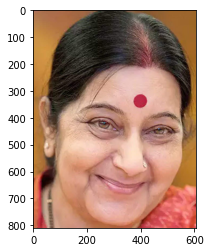

[[62.31083]]


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

 # This picture should be in the same directory from which the nb is running
picture = "/content/drive/My Drive/o.jpg"                                  
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

prediction = new_model.predict(loadImage(picture))
print(prediction)


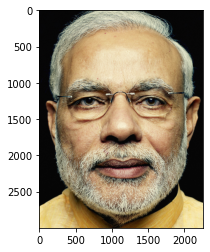

[[66.208206]]


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

 # This picture should be in the same directory from which the nb is running
picture = "/content/drive/My Drive/n.jpg"                                  
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

prediction = age_model.predict(loadImage(picture))
print(prediction)
